# P5: Identifying Fraud from Enron Emails

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives.

In this project, I use machine learning to identify persons of interest based on financial and email data made public as a result of the Enron scandal, as well as a labeled list of individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

## Goals and dataset



The goal of this project is to build a predictive model that can identify persons of interest based on features included in the Enron dataset. Such model could be used to find additional suspects who were not indicted during the original investigation, or to find persons of interest during fraud investigations at other businesses.

### Infomartion regarding dataset

In [1]:
%matplotlib inline

import sys
import pickle
import pprint
import math
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
print "Number of employees: {}".format(len(data_dict))

Number of employees: 146


In [4]:
# Employee names in this dataset
for employee in data_dict:
    print employee

METTS MARK
BAXTER JOHN C
ELLIOTT STEVEN
CORDES WILLIAM R
HANNON KEVIN P
MORDAUNT KRISTINA M
MEYER ROCKFORD G
MCMAHON JEFFREY
HORTON STANLEY C
PIPER GREGORY F
HUMPHREY GENE E
UMANOFF ADAM S
BLACHMAN JEREMY M
SUNDE MARTIN
GIBBS DANA R
LOWRY CHARLES P
COLWELL WESLEY
MULLER MARK S
JACKSON CHARLENE R
WESTFAHL RICHARD K
WALTERS GARETH W
WALLS JR ROBERT H
KITCHEN LOUISE
CHAN RONNIE
BELFER ROBERT
SHANKMAN JEFFREY A
WODRASKA JOHN
BERGSIEKER RICHARD P
URQUHART JOHN A
BIBI PHILIPPE A
RIEKER PAULA H
WHALEY DAVID A
BECK SALLY W
HAUG DAVID L
ECHOLS JOHN B
MENDELSOHN JOHN
HICKERSON GARY J
CLINE KENNETH W
LEWIS RICHARD
HAYES ROBERT E
MCCARTY DANNY J
KOPPER MICHAEL J
LEFF DANIEL P
LAVORATO JOHN J
BERBERIAN DAVID
DETMERING TIMOTHY J
WAKEHAM JOHN
POWERS WILLIAM
GOLD JOSEPH
BANNANTINE JAMES M
DUNCAN JOHN H
SHAPIRO RICHARD S
SHERRIFF JOHN R
SHELBY REX
LEMAISTRE CHARLES
DEFFNER JOSEPH M
KISHKILL JOSEPH G
WHALLEY LAWRENCE G
MCCONNELL MICHAEL S
PIRO JIM
DELAINEY DAVID W
SULLIVAN-SHAKLOVITZ COLLEEN
WROBEL BRUC

Strange two entries: TOTAL and THE TRAVEL AGENCY IN THE PARK. Let's inspect them. By inspecting them, TOTAL is clearly an outlier and seems to hold grand totals. The travel agency in the park is potentially not a person.

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}
{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_de

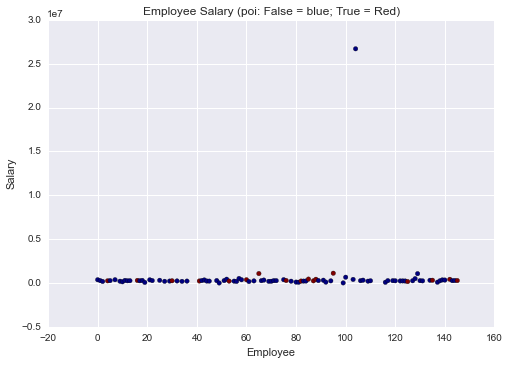

In [5]:
pprint.pprint(data_dict['THE TRAVEL AGENCY IN THE PARK'])
pprint.pprint(data_dict['TOTAL'])

y = []
t = []
for p in data_dict:
    t = t + [float(data_dict[p]['poi'])]
    y = y + [float(data_dict[p]['salary'])]

x = range(0, len(data_dict))

plt.scatter(x, y, c=t, cmap='jet')
plt.title('Employee Salary (poi: False = blue; True = Red)')
plt.xlabel('Employee')
plt.ylabel('Salary')

plt.show()

In [6]:
## Are there duplicates?
empl2set = set(data_dict.keys())
if len(empl2set) != len(data_dict):
    print "WARNING: DUPLICATES FOUND!"
else:
    print "NO DUPLICATES FOUND!"

NO DUPLICATES FOUND!


In [7]:
print "Number of features: {}".format(len(data_dict['TOTAL'].keys()))
pprint.pprint(data_dict['TOTAL'].keys())

Number of features: 21
['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']


In [8]:
#Let's see how many values are NaN
def NaN_counter(feature_name):
    "Calculates the percentage of NaNs in a feature"
    count_NaN = 0
    for employee in data_dict:
        if math.isnan(float(data_dict[employee][feature_name])):
            count_NaN += 1
    percent_NaN = 100*float(count_NaN)/float(len(data_dict))
    percent_NaN = round(percent_NaN,2)
    return percent_NaN

for feat in data_dict['TOTAL'].keys():
    if feat != 'email_address':
        print "NaNs in {}: {}".format(feat, NaN_counter(feat))


NaNs in salary: 34.93
NaNs in to_messages: 41.1
NaNs in deferral_payments: 73.29
NaNs in total_payments: 14.38
NaNs in exercised_stock_options: 30.14
NaNs in bonus: 43.84
NaNs in restricted_stock: 24.66
NaNs in shared_receipt_with_poi: 41.1
NaNs in restricted_stock_deferred: 87.67
NaNs in total_stock_value: 13.7
NaNs in expenses: 34.93
NaNs in loan_advances: 97.26
NaNs in from_messages: 41.1
NaNs in other: 36.3
NaNs in from_this_person_to_poi: 41.1
NaNs in poi: 0.0
NaNs in director_fees: 88.36
NaNs in deferred_income: 66.44
NaNs in long_term_incentive: 54.79
NaNs in from_poi_to_this_person: 41.1


In [9]:
#find number of persons of interest
poi = 0
npoi = 0
for p in data_dict:
    if data_dict[p]['poi']:
        poi += 1
    else:
        npoi += 1
print poi
print npoi

18
128


### Summary

The dataset contains a total of 146 data points, each with 21 features. Of the 146 records, 18 are labeled as persons of interest. Two of these entries are to be removed because they are not persons. 

Furthermore, there are some high percentages of NaN, as reported before, director with 88.36% being the feature with highest percentage of NaNs.

## Task 1: Select what features will be used.

In [10]:
# this list is augmented after Task 3.
features_list = ['poi', 'salary']

## Task 2: Remove outliers.

In [11]:
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)
data_dict.pop('TOTAL', 0)

print "\nNumber of employees: {}". format(len(data_dict) - 2)


Number of employees: 142


## Task 3: Create new feature(s)

In [12]:
#feature: wealth - salary, total stock value, exercised stock option, bonus.
for employee in data_dict:
    wealth = 0
    if not math.isnan(float(data_dict[employee]['exercised_stock_options'])):
        wealth += float(data_dict[employee]['exercised_stock_options'])
    if not math.isnan(float(data_dict[employee]['salary'])):
        wealth += float(data_dict[employee]['salary'])
    if not math.isnan(float(data_dict[employee]['bonus'])):
        wealth += float(data_dict[employee]['bonus'])
    if not math.isnan(float(data_dict[employee]['total_stock_value'])):
        wealth += float(data_dict[employee]['total_stock_value'])
    data_dict[employee]['wealth'] = wealth

    fPOI = 0
    sPOI = 0
    if not math.isnan(float(data_dict[employee]['from_poi_to_this_person'])):
        fPOI = float(data_dict[employee]['from_poi_to_this_person'])
    if not math.isnan(float(data_dict[employee]['from_this_person_to_poi'])):
        sPOI = float(data_dict[employee]['from_this_person_to_poi'])

    if fPOI + sPOI == 0:
        data_dict[employee]['ratio_sent_poi'] = 0
        data_dict[employee]['ratio_rcv_poi'] = 0
    else:
        data_dict[employee]['ratio_sent_poi'] = sPOI / (sPOI + fPOI)
        data_dict[employee]['ratio_rcv_poi'] = fPOI / (sPOI + fPOI)

I created three features:

- fraction_from_poi: Fraction of emails received from POIs.

- fraction_to_poi: Fraction of emails sent to POIs.

- wealth: Salary, total stock value, exercised stock options and bonuses.

Non of these features seemed to affect the performance of the algorithm using the selected features in the dataset. 

### After removing outliers, add new features to the dataset, and apply feature scaling, I am using SelectKBest to find the best features. This has been used to update the feature_list defined before.

#### Apply feature scaling

Since the range of values of raw data varies widely, to avoid potential artifacts in the classification algorithms, I am normalization the features using MinMaxScaler. This feature scaling has no, or marginal, impact on the classification algorithm. 

In [13]:
from sklearn.preprocessing import MinMaxScaler

flist = ['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'from_poi_to_this_person', 
 'wealth', 'ratio_sent_poi', 'ratio_rcv_poi']

### Store to my_dataset for easy export below.
my_dataset = data_dict

data = featureFormat(my_dataset, flist, sort_keys = True)
labels, features = targetFeatureSplit(data)

scaler = MinMaxScaler()
features = scaler.fit_transform(features)

print features

[[  1.91563800e-01   4.55198951e-01   4.33029255e-02 ...,   8.60184356e-02
    5.80357143e-01   4.19642857e-01]
 [  0.00000000e+00   4.31090330e-02   1.76193863e-03 ...,   6.07657893e-03
    0.00000000e+00   0.00000000e+00]
 [  3.73622021e-02   1.56980101e-02   8.84703391e-03 ...,   1.01897640e-01
    0.00000000e+00   1.00000000e+00]
 ..., 
 [  0.00000000e+00   1.56980101e-02   0.00000000e+00 ...,   3.48435575e-03
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.56980101e-02   3.47914948e-03 ...,   2.22694842e-01
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.56980101e-02   5.32030805e-04 ...,   4.65563605e-03
    0.00000000e+00   0.00000000e+00]]


In [14]:
kbest = SelectKBest(f_regression, k=5)

X_new = kbest.fit_transform(features, labels)

pairs = sorted(zip(flist, kbest.scores_), key=lambda x: x[1], reverse=True)
pprint.pprint(pairs)

[('exercised_stock_options', 102.45258245307906),
 ('deferred_income', 64.196870594214801),
 ('from_poi_to_this_person', 61.018831625055704),
 ('from_messages', 59.50983272624449),
 ('bonus', 57.412332328908235),
 ('restricted_stock_deferred', 52.526260661330944),
 ('deferral_payments', 49.913259030355412),
 ('restricted_stock', 49.551893864045951),
 ('total_payments', 35.552051858302754),
 ('ratio_sent_poi', 29.053305037434416),
 ('long_term_incentive', 27.75454727744739),
 ('salary', 25.995931831498421),
 ('expenses', 25.055852430123274),
 ('total_stock_value', 20.746799320558189),
 ('from_this_person_to_poi', 18.289684043404524),
 ('director_fees', 17.145051599663148),
 ('poi', 14.499919583848524),
 ('to_messages', 8.8086536471804227),
 ('other', 6.2248683163393395),
 ('wealth', 5.1926070546643492),
 ('loan_advances', 2.937617173118896),
 ('shared_receipt_with_poi', 1.1304454953978305)]


#### Extending feature_list

In [15]:
# this list is augmented after Task 3.
features_list = features_list + ['bonus', 
                                 'total_stock_value',
                                 'exercised_stock_options']

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

## Task 4: Try a varity of classifiers

#### GaussianNB

In [16]:
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

dump_classifier_and_data(clf, my_dataset, features_list)

import tester
tester.main()

GaussianNB()
	Accuracy: 0.84677	Precision: 0.50312	Recall: 0.32300	F1: 0.39342	F2: 0.34791
	Total predictions: 13000	True positives:  646	False positives:  638	False negatives: 1354	True negatives: 10362



#### KNeighborsClassifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='distance')

dump_classifier_and_data(clf, my_dataset, features_list)

import tester
tester.main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='distance')
	Accuracy: 0.87800	Precision: 0.69602	Recall: 0.36750	F1: 0.48102	F2: 0.40581
	Total predictions: 13000	True positives:  735	False positives:  321	False negatives: 1265	True negatives: 10679



#### DecisionTreeClassifier

In [18]:
from sklearn import tree
from sklearn.metrics import accuracy_score
clf = tree.DecisionTreeClassifier(min_samples_split=40)

dump_classifier_and_data(clf, my_dataset, features_list)

import tester
tester.main()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=40, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
	Accuracy: 0.82346	Precision: 0.26475	Recall: 0.08300	F1: 0.12638	F2: 0.09621
	Total predictions: 13000	True positives:  166	False positives:  461	False negatives: 1834	True negatives: 10539



## Task 5: Tune your classifier 

Tune your classifier to achieve better than .3 precision and recall using our testing script. Check the tester.py script in the final project folder for details on the evaluation method, especially the test_classifier function. Because of the small size of the dataset, the script uses stratified shuffle split cross validation. For more info: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

I have selected the KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_neighbors=5, p=2, weights='distance') classifier as the best performer because it shows better recall (i.e.the number of identified POIs divided by the total number of POIs) than the alternatives at the expense of precision (i.e., the proportion identified POIs, who actually are POIs). I believe however that recall is more important in this context. False positives can always be double-checked manually. 

In [19]:
clf = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', 
                           metric_params=None, n_neighbors=5, p=2, weights='distance')

from sklearn.cross_validation import train_test_split

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.5, random_state=42)
    
from sklearn.cross_validation import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(labels, 1000, random_state = 42)


for train_idx, test_idx in cv:
    features_train = []
    features_test  = []
    labels_train   = []
    labels_test    = []
    for ii in train_idx:
        features_train.append( features[ii] )
        labels_train.append( labels[ii] )
    for jj in test_idx:
        features_test.append( features[jj] )
        labels_test.append( labels[jj] )

    ### fit the classifier using training set, and test on test set
    clf.fit(features_train, labels_train)

dump_classifier_and_data(clf, my_dataset, features_list)

import tester
tester.main()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='distance')
	Accuracy: 0.87800	Precision: 0.69602	Recall: 0.36750	F1: 0.48102	F2: 0.40581
	Total predictions: 13000	True positives:  735	False positives:  321	False negatives: 1265	True negatives: 10679



The StratifiedShuffleSplit does not seem to have an impact in the classifier. 

#### Autotuning using GridSearchCV

Taken from https://en.wikipedia.org/wiki/Hyperparameter_optimization:

In the context of machine learning, hyperparameter optimization or model selection is the problem of choosing a set of hyperparameters for a learning algorithm, usually with the goal of optimizing a measure of the algorithm's performance on an independent data set. Often cross-validation is used to estimate this generalization performance.

The traditional way of performing hyperparameter optimization has been grid search, or a parameter sweep, which is simply an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set.

In [20]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from numpy import mean
import progressbar



def test_clf(grid_search, features, labels, parameters, iterations=100):
    precision, recall = [], []
    
    progress = progressbar.ProgressBar(widgets=[progressbar.Bar('=', '[', ']'), ' ',
                                            progressbar.Percentage(), ' ',
                                            progressbar.ETA()])
    
    for iteration in progress(range(iterations)):
        features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state=iteration)
        grid_search.fit(features_train, labels_train)
        predictions = grid_search.predict(features_test)
        precision = precision + [precision_score(labels_test, predictions)]
        recall = recall + [recall_score(labels_test, predictions)]
    print '\nPrecision:', mean(precision)
    print 'Recall:', mean(recall)
    best_params = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print '%s=%r, ' % (param_name, best_params[param_name])


parameters = {'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p' : [1, 2, 3], #
              'leaf_size': [10, 20, 30, 40],
              'n_neighbors': [1, 5, 10],
              'weights' : ['uniform', 'distance']}

#Note about p: Power parameter for the Minkowski metric. When p = 1, this is equivalent to using 
#manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance 
#(l_p) is used.

grid_search = GridSearchCV(clf, parameters, verbose=1, n_jobs=4)

grid_search.fit(features_train, labels_train)


#
#test_clf(grid_search, features, labels, parameters)
#
#import tester
#tester.main()

pprint.pprint(grid_search.grid_scores_)

best_params = grid_search.best_params_
for param_name in sorted(parameters.keys()):
     print '%s=%r, ' % (param_name, best_params[param_name])

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=4)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 jobs       | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 jobs       | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 450 jobs       | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 800 jobs       | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 858 out of 864 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 864 out of 864 | elapsed:    5.1s finished


[mean: 0.85470, std: 0.05107, params: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 10, 'algorithm': 'auto', 'p': 1},
 mean: 0.85470, std: 0.05107, params: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 10, 'algorithm': 'auto', 'p': 1},
 mean: 0.85470, std: 0.06114, params: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 10, 'algorithm': 'auto', 'p': 2},
 mean: 0.85470, std: 0.06114, params: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 10, 'algorithm': 'auto', 'p': 2},
 mean: 0.86325, std: 0.05035, params: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 10, 'algorithm': 'auto', 'p': 3},
 mean: 0.86325, std: 0.05035, params: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 10, 'algorithm': 'auto', 'p': 3},
 mean: 0.86325, std: 0.01481, params: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 10, 'algorithm': 'auto', 'p': 1},
 mean: 0.86325, std: 0.02977, params: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 10, 'algorithm': 'auto

I have now instantiated the classifier with the parameters given by the GridSearchCV, that is I use the KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski', metric_params=None, n_neighbors=5, p=1, weights='uniform') classifier. After stratifiying the data, the classifier yields better precision, but there is a decrease in recall. I would consider to use the other params instead of these ones becasue recall is arguably more important than precision.

In [22]:
clf = KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski', 
                           metric_params=None, n_neighbors=5, p=1, weights='uniform')

from sklearn.cross_validation import train_test_split

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.5, random_state=42)
    
from sklearn.cross_validation import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(labels, 1000, random_state = 42)


for train_idx, test_idx in cv:
    features_train = []
    features_test  = []
    labels_train   = []
    labels_test    = []
    for ii in train_idx:
        features_train.append( features[ii] )
        labels_train.append( labels[ii] )
    for jj in test_idx:
        features_test.append( features[jj] )
        labels_test.append( labels[jj] )

    ### fit the classifier using training set, and test on test set
    clf.fit(features_train, labels_train)

dump_classifier_and_data(clf, my_dataset, features_list)

import tester
tester.main()

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_neighbors=5, p=1, weights='uniform')
	Accuracy: 0.87392	Precision: 0.70078	Recall: 0.31500	F1: 0.43463	F2: 0.35397
	Total predictions: 13000	True positives:  630	False positives:  269	False negatives: 1370	True negatives: 10731



## Validation and Evaluation

Evaluation allows to evaluate the performance of a algorithm. Validation allows to get a better idea of how our algorithm will perform when faced with unseen data. It gives us more evidence to draw conclusions wrt.  generalization beyond the dataset used to train it (overfitting). One of the biggest mistakes one can make is to use the same data fro training and testing.

To cross validate, I used skilearn train_test_split, which splits the data into into random train and test subsets. I ran 1000 randomized trials and evaluated the mean evaluation metrics. Given the imbalance in the dataset betweet POIs and non-POIs, accuracy would not have been an appropriate evaluation metric. I used precision and recall instead:

In [24]:
precision, recall = [], []
progress = progressbar.ProgressBar(widgets=[progressbar.Bar('=', '[', ']'), ' ',
                                            progressbar.Percentage(), ' ',
                                            progressbar.ETA()])
for it in progress(range(1000)):
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state=it)
    clf.fit(features_train, labels_train)
    predictions = clf.predict(features_test)
    precision = precision + [precision_score(labels_test, predictions)]
    recall = recall + [recall_score(labels_test, predictions)]
        
print '\nPrecision:', mean(precision)
print 'Recall:', mean(recall)


Precision: 0.596983333333
Recall: 0.250828174603


## Conclusions

I wasn't able to find other features that would improve the classifier. KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski', metric_params=None, n_neighbors=5, p=1, weights='uniform') gave best results after feature scaling with MinMaxScaler and tuning with GridSearchCV.